# Training an Autoencoder for Feature Compression

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

# Dataset

In [381]:
data = pd.read_csv('sonar.all-data', header=None)
data.shape

(208, 61)

Let's separate the data into two classes, 'rocks' and 'mines'. The attribute `iloc` will be used to drop the class label.

In [382]:
rocks = data[data[60] == 'R'].iloc[:, :-1] 
mines = data[data[60] == 'M'].iloc[:, :-1]

rocks.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


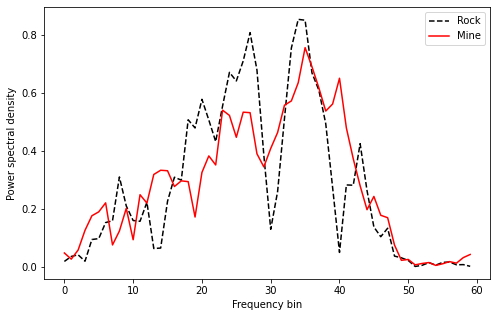

In [383]:
plt.figure(figsize=(8,5))
plt.plot(rocks.values[0], label='Rock', c='black', linestyle='--')
plt.plot(mines.values[0], label='Mine', c='red')
plt.xlabel('Frequency bin')
plt.ylabel('Power spectral density')
plt.legend()
plt.show()

# Re-formatting the data as a tensor

In [446]:
features = data.iloc[:, :-1]

# The data must be float32, or application of the model will give rise to an error.
feature_tensor = torch.tensor(features.values, dtype=torch.float32)
feature_tensor.dtype

torch.float32

# Building the autoencoder

In [463]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Linear encoder composed of linear layers alternating with sigmoidal activation functions
        # Compress input from sixty features to five features
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(60, 52),
            torch.nn.ReLU(),
            torch.nn.Linear(52, 44),
            torch.nn.ReLU(),
            torch.nn.Linear(44, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 5)
        )
        
        # Linear decoder that maps five features back to sixty
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 44),
            torch.nn.ReLU(),
            torch.nn.Linear(44, 52),
            torch.nn.ReLU(),
            torch.nn.Linear(52, 60),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [464]:
model #model summary

AE(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=52, bias=True)
    (1): ReLU()
    (2): Linear(in_features=52, out_features=44, bias=True)
    (3): ReLU()
    (4): Linear(in_features=44, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=24, bias=True)
    (7): ReLU()
    (8): Linear(in_features=24, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=44, bias=True)
    (7): ReLU()
    (8): Linear(in_features=44, out_features=52, bias=True)
    (9): ReLU()
    (10): Linear(in_features=52, out_features=60, bias=True)
    (11): Sigmoid()
  )
)

In [465]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training the autoencoder

In [466]:
model = AE()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_parameters(model)

16497

In [467]:
data_loader = torch.utils.data.DataLoader(feature_tensor, batch_size=12, shuffle=False)

epochs = 4000
outputs = []
losses = []

for epoch in range(epochs):
    loss = 0
    for batch_features in data_loader:
        
        # Apply the autoencoder:
        reconstruction = model(batch_features)
        
        # Compute the loss:
        train_loss = criterion(reconstruction, batch_features)
        
        # Set gradients to zero:
        optimizer.zero_grad() 
        
        # Compute gradients:
        train_loss.backward()
        
        # Update learnable parameters based on gradient evaluation:
        optimizer.step()
    
        # Add to the loss:
        loss += train_loss.item()
    
        if epoch == epochs-1:
            outputs.append([batch_features, reconstruction])
            
    # Compute the loss averaged over the epoch, then add it to 'losses':
    loss = loss/len(data_loader)
    losses.append(loss)
    
    if (epoch+1) % 100 == 0:
        print("Epoch:{}/{}, loss={}".format(epoch+1, epochs, loss))

Epoch:100/4000, loss=0.013880339205368526
Epoch:200/4000, loss=0.012275514632670416
Epoch:300/4000, loss=0.010627227279150652
Epoch:400/4000, loss=0.009414780652150512
Epoch:500/4000, loss=0.008241080633726798
Epoch:600/4000, loss=0.007296246851587461
Epoch:700/4000, loss=0.006597678403421823
Epoch:800/4000, loss=0.006219408992264006
Epoch:900/4000, loss=0.007773587273226844
Epoch:1000/4000, loss=0.005632005153327352
Epoch:1100/4000, loss=0.005260480451397598
Epoch:1200/4000, loss=0.0060200936406747335
Epoch:1300/4000, loss=0.004675179910716704
Epoch:1400/4000, loss=0.004508163010339356
Epoch:1500/4000, loss=0.004524688081194957
Epoch:1600/4000, loss=0.005226540954835299
Epoch:1700/4000, loss=0.0039675575616355575
Epoch:1800/4000, loss=0.00372153174248524
Epoch:1900/4000, loss=0.003924109035223309
Epoch:2000/4000, loss=0.003617163375666779
Epoch:2100/4000, loss=0.003330316038854006
Epoch:2200/4000, loss=0.0028473696826646724
Epoch:2300/4000, loss=0.002974903925658307
Epoch:2400/4000, l

# Plotting the loss

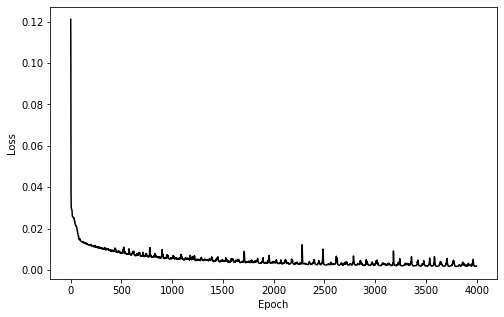

In [468]:
plt.figure(figsize=(8,5))
plt.plot(losses, color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

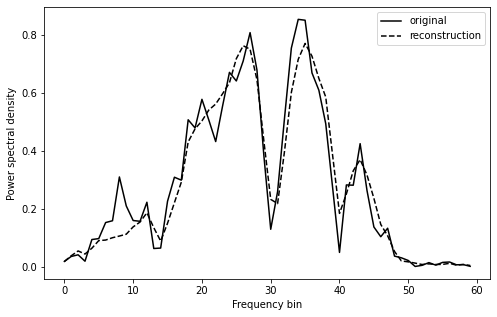

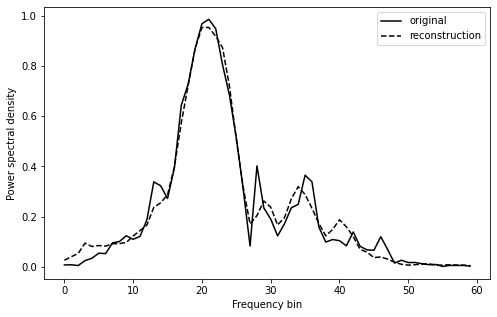

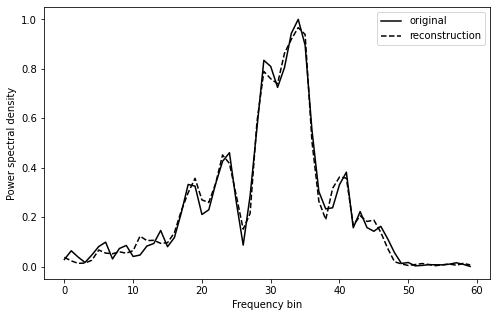

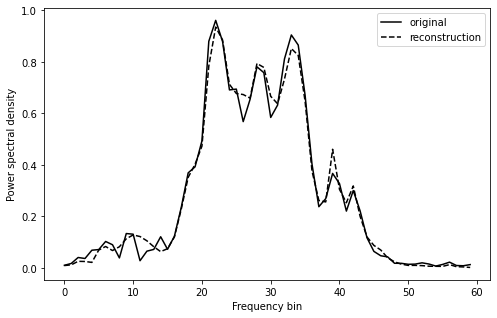

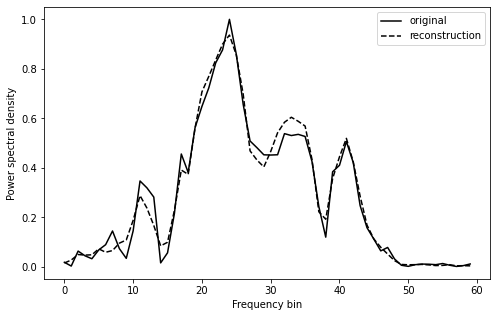

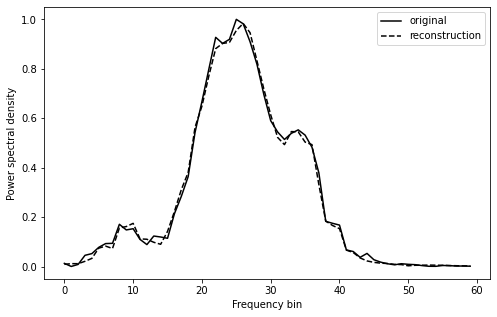

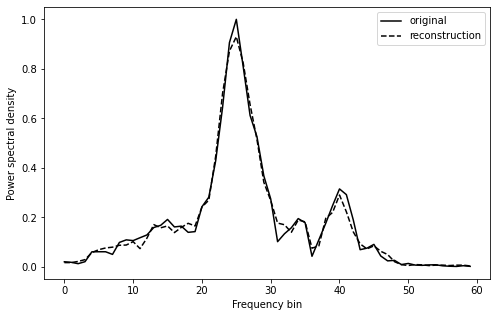

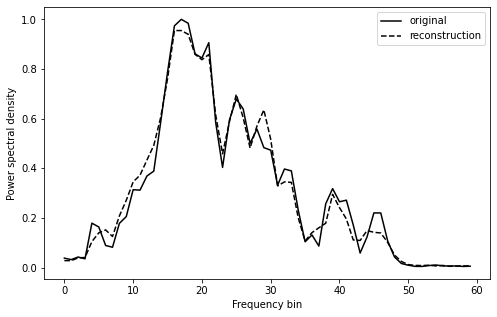

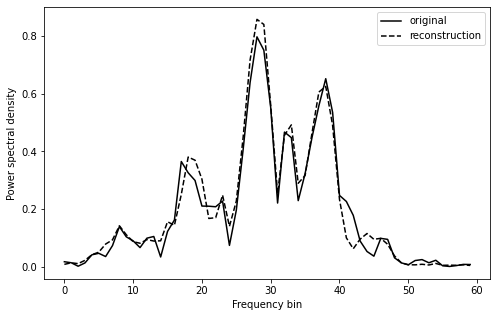

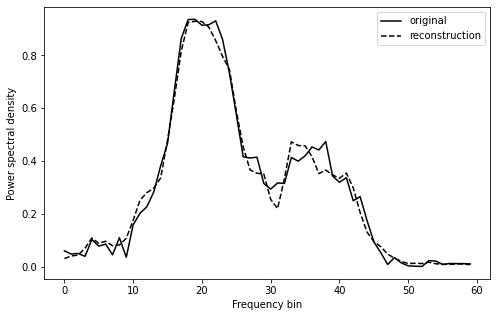

In [469]:
# Example of reconstruction
def compare(sample):
    original, reconstruction = outputs[sample]
    plot = plt.figure(figsize=(8,5))
    plt.plot(original[0].numpy(), label='original', color='black')
    plt.plot(reconstruction[0].detach().numpy(), label='reconstruction', color='black', linestyle='--')
    plt.xlabel('Frequency bin')
    plt.ylabel('Power spectral density')
    plt.legend()
    return plot

for i in range(10):
    compare(i)

# Saving/loading the model

In [472]:
torch.save(model.state_dict(), 'trained-autoencoder.pth')
model = AE()
model.load_state_dict(torch.load('trained-autoencoder.pth'))
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=52, bias=True)
    (1): ReLU()
    (2): Linear(in_features=52, out_features=44, bias=True)
    (3): ReLU()
    (4): Linear(in_features=44, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=24, bias=True)
    (7): ReLU()
    (8): Linear(in_features=24, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=44, bias=True)
    (7): ReLU()
    (8): Linear(in_features=44, out_features=52, bias=True)
    (9): ReLU()
    (10): Linear(in_features=52, out_features=60, bias=True)
    (11): Sigmoid()
  )
)

# Compressing the data

In [486]:
labels = data.iloc[:,-1:]
compressed_features = model.encoder(feature_tensor).detach().numpy()
compressed_data = np.append(compressed_features, labels, axis=1)
compressed_data = pd.DataFrame(compressed_data)
compressed_data.head()

,0,1,2,3,4,5
0,2.788435,2.103543,0.426437,0.581858,2.39614,R
1,-1.307888,-2.164024,-1.066672,-1.51755,0.061261,R
2,-1.298477,-2.415981,-3.042823,-2.050905,-0.316739,R
3,0.39522,-0.696221,-4.280332,-0.840407,-0.300237,R
4,0.36932,0.290131,-1.010054,-0.369055,-0.462238,R


In [487]:
compressed_data.to_csv('AE-compressed-data.csv')